# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import tensorflow as tf

notebook_dir = os.getcwd()          # e.g., norepo/notebooks
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from lib.network import Sequential
from lib.layers import Dense, BaseLayer
from lib.activations import Tanh,ReLU,Sigmoid
from lib.losses import MeanSquaredError
from lib.optimizer import GD

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers

# Utils

In [7]:
def plot_loss_curve(loss_history, title="Training Loss", xlabel="Epochs", ylabel="Loss (MSE)"):
    """
    Plots the training loss curve.

    Args:
        loss_history (list or np.array): List of loss values recorded during training.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label="Training Loss", color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_reconstruction(model, X_test, n_samples=5):
    """
    Visualizes original vs reconstructed images from the autoencoder.

    Args:
        model: Trained autoencoder model (must have a .predict() method).
        X_test: Test data with shape (features, n_samples).
                For MNIST, features should be 784.
        n_samples: Number of random samples to display.
    """
    # Ensure n_samples does not exceed available test samples
    n_samples = min(n_samples, X_test.shape[1])

    # Select random samples
    indices = np.random.choice(X_test.shape[1], n_samples, replace=False)
    original_samples = X_test[:, indices] # Shape: (784, n_samples)

    # Predict (Reconstruct)
    reconstructed_samples = model.predict(original_samples) # Shape: (784, n_samples)

    # Plotting
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2.5, 5))

    # Handle single sample case where axes might not be 2D array
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)

    for i in range(n_samples):
        # Original Image
        ax_orig = axes[0, i]
        # Reshape from flat vector (784,) to 2D image (28, 28)
        img_orig = original_samples[:, i].reshape(28, 28)
        ax_orig.imshow(img_orig, cmap='gray')
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title("Original", fontsize=12)

        # Reconstructed Image
        ax_recon = axes[1, i]
        img_recon = reconstructed_samples[:, i].reshape(28, 28)
        ax_recon.imshow(img_recon, cmap='gray')
        ax_recon.axis('off')
        if i == 0:
            ax_recon.set_title("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()


def visualize_reconstruction_tf(model, X_test, n_samples=5):
    """
    Visualizes original vs reconstructed images from a TensorFlow autoencoder.

    Args:
        model: Trained tf.keras autoencoder.
        X_test: Test data with shape (n_samples, 784).
        n_samples: Number of random samples to display.
    """
    n_samples = min(n_samples, X_test.shape[0])

    # Select random samples
    indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    original_samples = X_test[indices]          # (n_samples, 784)

    # Reconstruct
    reconstructed_samples = model.predict(original_samples)

    # Plot
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2.5, 5))

    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)

    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original_samples[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original")

        # Reconstructed
        axes[1, i].imshow(reconstructed_samples[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


In [8]:
def load_and_preprocess_mnist(limit=5000):
    """
    Loads MNIST data and preprocesses it for our custom library.

    Args:
        limit (int): Number of samples to use for training.
    """
    # 1. Load Data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # 2. Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # 3. Flatten images (Batch, 28, 28) -> (Batch, 784)
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    # 4. Transpose to (Features, Batch_Size)
    # Dense layer computes np.dot(W, x), so x must be column vectors.
    X_train = x_train.T[:, :limit]
    Y_train_labels = y_train[:limit]

    X_test = x_test.T[:, :100] # Use smaller subset for testing
    Y_test_labels = y_test[:100]

    return X_train, Y_train_labels, X_test, Y_test_labels

def one_hot_encode(labels, num_classes=10):
    """One-hot encodes labels for classification target."""
    m = len(labels)
    one_hot = np.zeros((num_classes, m))
    for i, label in enumerate(labels):
        one_hot[label, i] = 1
    return one_hot


# Part 1

In [ ]:

# --- Gradient Check Function ---
def check_gradients(model, X, Y, epsilon=1e-7):
    """
    Compares analytical gradients (from backprop) with numerical gradients (finite difference).
    A relative error < 1e-7 confirms the backpropagation implementation is correct.
    """
    # 1. Run forward and backward pass to calculate analytical gradients (dA, db)
    Y_pred = model.forward(X)
    model.backward(Y_pred, Y)

    for idx, layer in enumerate(model.layers):
        # Only check layers with parameters (Dense)
        if not hasattr(layer, 'A') or not hasattr(layer, 'b'):
            continue  # skip this layer because it has no trainable parameters


        print(f"\nChecking Layer {idx+1} ({layer.__class__.__name__})...")

        # --- Check Weights (A) ---
        num_grad_A = np.zeros_like(layer.A)
        it = np.nditer(layer.A, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            i = it.multi_index
            orig = layer.A[i]

            # L(W + epsilon)
            layer.A[i] = orig + epsilon
            L_plus = model.loss_function.loss(model.forward(X), Y)

            # L(W - epsilon)
            layer.A[i] = orig - epsilon
            L_minus = model.loss_function.loss(model.forward(X), Y)

            # Restore original value
            layer.A[i] = orig

            # Numerical gradient approximation
            num_grad_A[i] = (L_plus - L_minus) / (2 * epsilon)
            it.iternext()

        # --- Check Biases (b) ---
        num_grad_b = np.zeros_like(layer.b)
        it = np.nditer(layer.b, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            i = it.multi_index
            orig = layer.b[i]

            # L(b + epsilon)
            layer.b[i] = orig + epsilon
            L_plus = model.loss_function.loss(model.forward(X), Y)


            # L(b - epsilon)
            layer.b[i] = orig - epsilon
            L_minus = model.loss_function.loss(model.forward(X), Y)

            # Restore original value
            layer.b[i] = orig

            # Numerical gradient approximation
            num_grad_b[i] = (L_plus - L_minus) / (2 * epsilon)
            it.iternext()

        # Compare analytical vs numerical (Relative Error)
        # Added 1e-12 to denominator to prevent division by zero if all values are zero
        diff_A = np.linalg.norm(num_grad_A - layer.dA) / (np.linalg.norm(num_grad_A) + np.linalg.norm(layer.dA) + 1e-12)
        diff_b = np.linalg.norm(num_grad_b - layer.db) / (np.linalg.norm(num_grad_b) + np.linalg.norm(layer.db) + 1e-12)

        print(f"  Weight Gradient Diff (A): {diff_A:.10f}")
        print(f"  Bias Gradient Diff (b):   {diff_b:.10f}")

        if diff_A < 1e-7 and diff_b < 1e-7:
            print("  Status: Backprop Correct")
        else:
            print("  Status: Check Gradients (Error too high)")

# --- Build Simple Test Network for Gradient Check (2-2-1) ---
grad_check_model = Sequential()
grad_check_model.add(Dense(input_size=2, output_size=2, init_scale=0.1))
grad_check_model.add(Tanh())
grad_check_model.add(Dense(input_size=2, output_size=1, init_scale=0.1))
grad_check_model.add(Tanh())
grad_check_model.compile(optimizer=GD(learning_rate=0.01), loss_function=MeanSquaredError())

# --- Run Gradient Check ---
# Using a single sample for simplicity
X_check = np.array([[-1.0], [0.5]])
Y_check = np.array([[-1.0]])

print("Starting Gradient Check on Test Network...")
check_gradients(grad_check_model, X_check, Y_check)

# Data in (Features x Samples) format
X_xor = np.array([[-1, -1, 1, 1], [-1, 1, -1, 1]], dtype=np.float32) # (2, 4)
Y_xor = np.array([[-1, 1, 1, -1]], dtype=np.float32)                 # (1, 4)

# Build XOR Network (2 inputs -> 4 hidden -> 1 output)
xor_check_model = Sequential()
xor_check_model.add(Dense(input_size=2, output_size=4, init_scale=0.01))
xor_check_model.add(Tanh())
xor_check_model.add(Dense(input_size=4, output_size=1, init_scale=0.01))
xor_check_model.add(Tanh())
xor_check_model.compile(optimizer=GD(learning_rate=0.001), loss_function=MeanSquaredError())

print("\n\nStarting Gradient Check on XOR Network (2-4-1 Tanh)...")
check_gradients(xor_check_model, X_xor[:, [0]], Y_xor[:, [0]])



In [ ]:
#XOR Dataset
X_xor = np.array([[-1, -1,  1,  1],
                  [-1,  1, -1,  1]])

Y_xor = np.array([[-1,  1,  1, -1]]) 

#network
xor_model = Sequential()
xor_model.add(Dense(input_size=2, output_size=4, init_scale=0.1))
xor_model.add(Tanh())
xor_model.add(Dense(input_size=4, output_size=1, init_scale=0.1))
xor_model.add(Tanh())

#Hyperparameters
LR = 0.5
EPOCHS = 10000
xor_model.compile(optimizer=GD(learning_rate=LR), loss_function=MeanSquaredError())



loss_history = xor_model.train(X_xor, Y_xor, epochs=EPOCHS)
Y_pred_raw = xor_model.predict(X_xor)
Y_pred_class = np.where(Y_pred_raw >= 0, 1, -1)


# --- Display Results ---
print("\nFinal XOR Predictions:")
print("------------------------")
print("Input (X):\n", X_xor.T)
print("Target (Y):\n", Y_xor.T)
print("\nRaw Prediction (Tanh Output):\n", Y_pred_raw.T)
print("Classified Prediction:\n", Y_pred_class.T)
print(f"\nFinal Loss: {loss_history[-1]:.6f}")


# --- Plot Loss Curve ---
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("XOR Training Loss Curve (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
X_xor_test = np.array([[5],
                  [5]])

Y_pred_raw = xor_model.predict(X_xor_test)


# --- Display Results ---
print("\nFinal XOR Predictions:")
print("------------------------")
print("Input (X):\n", X_xor_test.T)
print("Target (Y):\n", Y_xor.T)
print("\nRaw Prediction (Tanh Output):\n", Y_pred_raw.T)
print("Classified Prediction:\n", Y_pred_class.T)
print(f"\nFinal Loss: {loss_history[-1]:.6f}")


# --- Plot Loss Curve ---
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("XOR Training Loss Curve (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
##XOR Dataset
X_xor = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype=np.float32)
Y_xor = np.array([[-1], [1], [1], [-1]], dtype=np.float32)


#network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_dim=2, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
])

#Hyperparameters
LR = 0.5
EPOCHS = 10000

optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
model.compile(optimizer=optimizer, loss='mean_squared_error')





history = model.fit(X_xor, Y_xor, epochs=EPOCHS, verbose=0)
loss_history = history.history['loss']
Y_pred_raw = model.predict(X_xor)
Y_pred_class = np.where(Y_pred_raw >= 0, 1, -1)

# --- Display Results ---
print("\nFinal XOR Predictions:")
print("------------------------")
print("Input (X):\n", X_xor.T)
print("Target (Y):\n", Y_xor.T)
print("\nRaw Prediction (Tanh Output):\n", Y_pred_raw.T)
print("Classified Prediction:\n", Y_pred_class.T)
print(f"\nFinal Loss: {loss_history[-1]:.6f}")

# --- Plot Loss Curve ---
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("XOR Training Loss Curve (TensorFlow/MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Part 2

# Custom Autoencoder for MNIST Reconstruction

In [9]:
# Increase limit to 20,000 to learn better generalized features
print("Loading Data...")
X_train, Y_train_labels, X_test, Y_test_labels = load_and_preprocess_mnist(limit=20000)
print(f"Training Data Shape: {X_train.shape}")

Loading Data...
Training Data Shape: (784, 20000)


In [34]:
autoencoder = Sequential()

# -- Encoder --
autoencoder.add(Dense(input_size=784, output_size=256, init_scale=0.05))
autoencoder.add(ReLU())

autoencoder.add(Dense(input_size=256, output_size=64, init_scale=0.088))
autoencoder.add(ReLU())

# -- Decoder --
autoencoder.add(Dense(input_size=64, output_size=256, init_scale=0.177))
autoencoder.add(ReLU())

autoencoder.add(Dense(input_size=256, output_size=784, init_scale=0.088))
autoencoder.add(Sigmoid())


In [14]:
optimizer = GD(learning_rate=0.1)
loss_func = MeanSquaredError()
autoencoder.compile(optimizer, loss_func)


print("\nTraining Autoencoder...")
loss_history = autoencoder.train(X_train, X_train, epochs=20, batch_size=64)


Training Autoencoder...
Epoch 1/20 - Loss: 40.617531
Epoch 2/20 - Loss: 25.785376
Epoch 3/20 - Loss: 23.386697
Epoch 4/20 - Loss: 21.019403
Epoch 5/20 - Loss: 19.046901
Epoch 6/20 - Loss: 17.484484
Epoch 7/20 - Loss: 16.201858
Epoch 8/20 - Loss: 15.131521
Epoch 9/20 - Loss: 14.236694
Epoch 10/20 - Loss: 13.472410
Epoch 11/20 - Loss: 12.811969
Epoch 12/20 - Loss: 12.244393
Epoch 13/20 - Loss: 11.747100
Epoch 14/20 - Loss: 11.307796
Epoch 15/20 - Loss: 10.917109
Epoch 16/20 - Loss: 10.564889
Epoch 17/20 - Loss: 10.241967
Epoch 18/20 - Loss: 9.947836
Epoch 19/20 - Loss: 9.674217
Epoch 20/20 - Loss: 9.422084


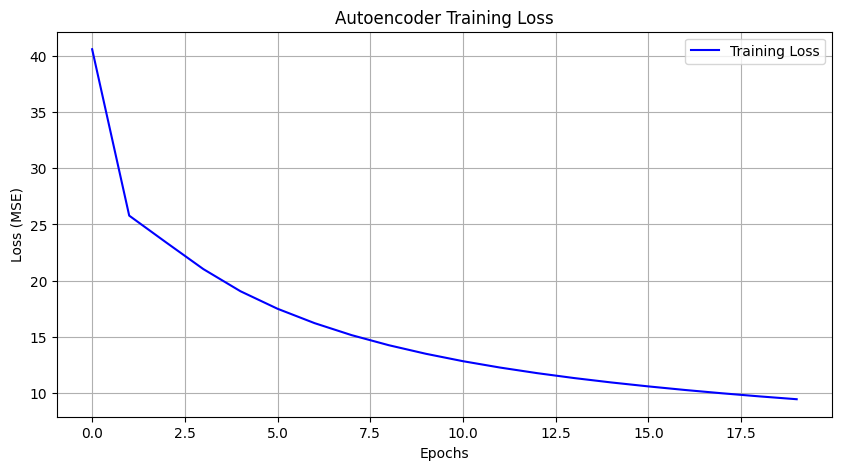

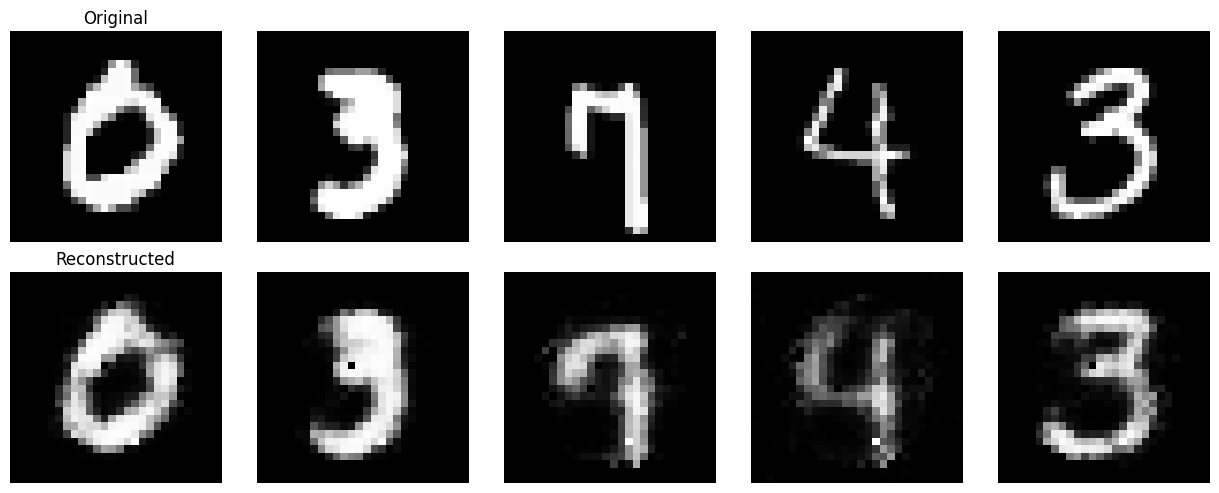

In [15]:
plot_loss_curve(loss_history, title="Autoencoder Training Loss")
visualize_reconstruction(autoencoder, X_test, n_samples=5)

# Latent Space SVM Classification

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [17]:
encoder = Sequential()

# Reuse the trained Encoder layers (Transfer Learning)
# Indices 0-3 correspond to: Dense(784->256) -> ReLU -> Dense(256->64) -> ReLU
for i in range(4):
    encoder.add(autoencoder.layers[i])

In [18]:
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

print(f"Latent Training Shape (Original): {X_train_latent.shape}")

# 2. Transpose for Scikit-Learn
# Convert (64, 20000) -> (20000, 64)
X_train_latent = X_train_latent.T
X_test_latent = X_test_latent.T

print(f"Latent Training Shape (Transposed): {X_train_latent.shape}")


Latent Training Shape (Original): (64, 20000)
Latent Training Shape (Transposed): (20000, 64)



Training SVM Classifier...
Evaluating Performance...

Test Accuracy: 97.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00        14
           2       0.80      1.00      0.89         8
           3       1.00      1.00      1.00        11
           4       1.00      0.93      0.96        14
           5       1.00      0.86      0.92         7
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        15
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00        11

    accuracy                           0.97       100
   macro avg       0.97      0.93      0.94       100
weighted avg       0.98      0.97      0.97       100



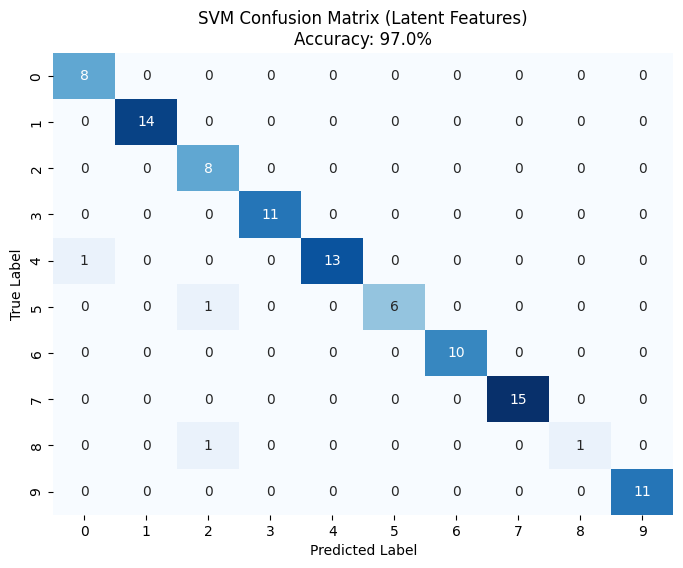

In [19]:
print("\nTraining SVM Classifier...")
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_latent, Y_train_labels)

# 3. Evaluation
print("Evaluating Performance...")
y_pred = svm.predict(X_test_latent)

# Calculate Metrics
acc = accuracy_score(Y_test_labels, y_pred)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(Y_test_labels, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(Y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"SVM Confusion Matrix (Latent Features)\nAccuracy: {acc*100:.1f}%")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# TensorFlow/Keras Baseline Comparison

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.optimizers import Adam
# USING SGD results in a model that gives up and outputs the average pixel value of the entire dataset.

T_X_train = X_train.T
T_X_test = X_test.T

# Build Autoencoder
autoencoder = models.Sequential([
    # ----- Encoder -----
    layers.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),

    # ----- Decoder -----
    layers.Dense(256, activation='relu'),
    layers.Dense(784, activation='sigmoid')
])

# Compile
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError()
)

# Summary (optional but useful)
autoencoder.summary()

# Train
history = autoencoder.fit(
    T_X_train, T_X_train,
    epochs=200,
    batch_size=64,
    shuffle=True
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,536 (1.66 MB)

 Trainable params: 435,536 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0456
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 9/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 10/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062
Epoch 11/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060
Epoch 12/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0058
Epoch 13/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056
Epoch 14/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055
Epoch 15/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1

(20000, 784)


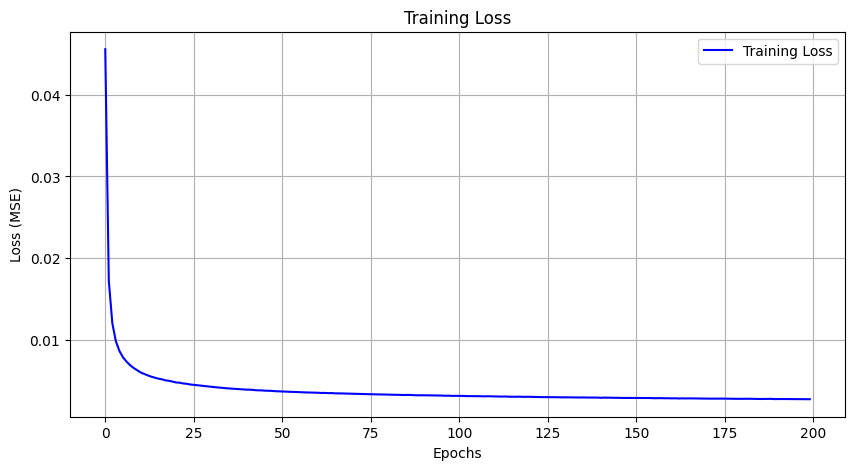

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


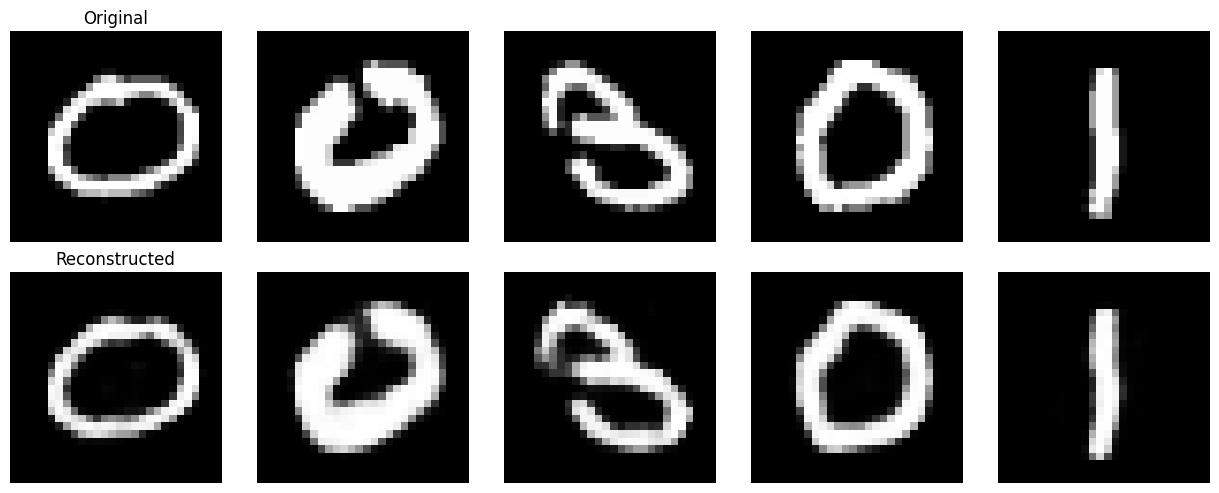

In [17]:
print(T_X_train.shape)
plot_loss_curve(history.history["loss"])
visualize_reconstruction_tf(
    model=autoencoder,
    X_test=T_X_test,
    n_samples=5
)